# Notebook dedicated to construct the train dataset of solar Nue and 208Tl events

Convention to define the size of train and test data set: The last two files in the list of directories of .root files are for test. The observables ['evtid', 'energy', 'posr', 'cos_alpha', 'hit_residual'] were already saved

In [1]:
import uproot
import numpy as np
import pandas as pd
import random
from joblib import Parallel, delayed
import numpy as np
import scipy.stats
from scipy.stats import wasserstein_distance
from scipy.stats import entropy

import glob
import re
import os 

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# Useful Functions

In [2]:
def chi2_metric(h_ev, h_ref, eps=1e-12):

    '''
    Function that computes the reduced Chi-square between two data distributions.
    Parameters:
    - h_ev: Histogram  of the event 
    - h_ref: Histogram of the high stat. model
    ' eps: smoothing factor to avoid division by zero
    '''
    
    h_ev = np.asarray(h_ev, dtype=float)
    h_ref = np.asarray(h_ref, dtype=float)
    
    #Distribution Normalization
    h_ev /= (np.sum(h_ev) + eps)
    h_ref /= (np.sum(h_ref) + eps)
    return np.sum((h_ev - h_ref)**2 / (h_ref + eps))

def js_distance(h_ev, h_ref, eps=1e-12):

    '''
    Function that computes the Jensen-Shannon Distance between two data distributions.
    Parameters:
    - h_ev: Histogram  of the event 
    - h_ref: Histogram of the high stat. model
    ' eps: smoothing factor to avoid division by zero
    '''
    
    #Distribution Normalization
    p = h_ev / (np.sum(h_ev) + eps)
    q = h_ref / (np.sum(h_ref) + eps)
    m = 0.5 * (p + q)
    
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def emd_metric(h_ev, h_ref, bin_centers):
    
    '''
    Function that computes the Wasserstein Distance or Earth Mover’s Distance (EMD) between two data distributions.
    Parameters:
    - h_ev: Histogram  of the event 
    - h_ref: Histogram of the high stat. model
    ' bin_centers: bin centers (x-value) of the histogram
    '''

    #Distribution Normalization
    p = h_ev / np.sum(h_ev)
    q = h_ref / np.sum(h_ref)
    
    return wasserstein_distance(bin_centers, bin_centers, p, q)

# Load Numpy files

In [3]:
# ============ Data Cuts Settings ============
energy_inf_cut = 2.5
energy_sup_cut = 12

posr_cut = 5500

time_res_inf_cut = -1
time_res_sup_cut = 5

nhits_cut = 20 #Nhits cut to be applied after the time residual cuts

#Δα Images cuts: 
image_dim = (10,10)
range_time = (time_res_inf_cut, time_res_sup_cut)
range_cos = (-1, 1)
# ============================================

main_dir = f'E:/Data/solars/mc/ML Data/np_arrays/Test/E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns/'
solar_fpattern = 'SolarNue_'
tl208_fpattern = '208Tl_'

observable_name = ['evtid', 'energy', 'posr', 'cos_alpha', 'hit_residual']

solar_dict = {var_i: np.array([]) for var_i in observable_name}
tl208_dict = {var_i: np.array([]) for var_i in observable_name}

#Load each varibles within a loop of variables and fill the dictionaries
#Loop over var names
for var_i in observable_name:
    #create flist for the multiple var_i observables (exm: evID_0, evID_1, ...)
    solar_var_i_flist = glob.glob(main_dir + solar_fpattern + var_i + '*.npy')
    tl208_var_i_flist = glob.glob(main_dir + tl208_fpattern + var_i + '*.npy')

    #Loop over flist:
    for solar_file_i in solar_var_i_flist:
        load_solar_var_i = np.load(solar_file_i)
        solar_dict[var_i] = np.append(solar_dict[var_i], load_solar_var_i)

    for tl208_file_i in tl208_var_i_flist:
        load_208tl_var_i = np.load(tl208_file_i)
        tl208_dict[var_i] = np.append(tl208_dict[var_i], load_208tl_var_i)

In [4]:
tl208_dict

{'evtid': array([   0.,    0.,    0., ..., 1454., 1454., 1454.]),
 'energy': array([3.14901996, 3.14901996, 3.14901996, ..., 3.27895021, 3.27895021,
        3.27895021]),
 'posr': array([4387.66796875, 4387.66796875, 4387.66796875, ..., 4014.53466797,
        4014.53466797, 4014.53466797]),
 'cos_alpha': array([-0.70663985, -0.69780774, -0.79526323, ..., -0.52800975,
        -0.59804558,  0.25650832]),
 'hit_residual': array([4.32053337, 1.94465363, 0.62809141, ..., 1.78848165, 4.65361585,
        3.87683858])}

## Remove Redundant Values

In [5]:
#Extract the redundant evID
solar_evID = solar_dict['evtid']
tl208_evID = tl208_dict['evtid']

redundant_observables_name = ['evtid', 'posr', 'energy'] #List of observables with redundant values to cut

# Empty lists which will contain the non-repeated values of the observables for singles events
solar_dict_ev = {var_i: [] for var_i in redundant_observables_name}
tl208_dict_ev = {var_i: [] for var_i in redundant_observables_name}

#evID index break list
solar_data_break_i = [0]  #array whose elements are the index from where an event start and end.
tl208_data_break_i = [0]

solar_N_data = len(solar_evID)
tl208_N_data = len(tl208_evID)

print('Looking for break index in solars evID')
for i_dx in range(solar_N_data - 1):
    if solar_evID[i_dx] != solar_evID[i_dx+1]:
        solar_data_break_i.append(i_dx+1)

print('Looking for break index in 208Tl evID')
for i_dx in range(tl208_N_data - 1):
    if tl208_evID[i_dx] != tl208_evID[i_dx+1]:
        tl208_data_break_i.append(i_dx+1)

#add the last index to complete the data_break_i list
solar_data_break_i.append(solar_N_data - 1)
tl208_data_break_i.append(tl208_N_data - 1)

N_solar_terms = len(solar_data_break_i)
N_tl208_terms = len(tl208_data_break_i)

#Start to save the non-redundant values and separate the time residuals and angles for each event
#Solar Loop
print(f'saving the non-redundant values for solars')
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    for var_i in redundant_observables_name:
        non_redundant_var_i_value = solar_dict[var_i][init_i : final_i][0]
        solar_dict_ev[var_i].append(non_redundant_var_i_value)

#Transform to array
print('Transforming solars to np.array')
for var_i in redundant_observables_name:
    solar_dict_ev[var_i] = np.array(solar_dict_ev[var_i])

#Now append time residual and cos_alpha to solars
solar_dict_ev['cos_alpha'] = solar_dict['cos_alpha']
solar_dict_ev['hit_residual'] = solar_dict['hit_residual']

#208Tl Loop
print('Transforming 208Tl to np.array')
print(f'saving the non-redundant values for 208Tl')
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]

    for var_i in redundant_observables_name:
        non_redundant_var_i_value = tl208_dict[var_i][init_i : final_i][0]
        tl208_dict_ev[var_i].append(non_redundant_var_i_value)

#Transform to array
for var_i in redundant_observables_name:
    tl208_dict_ev[var_i] = np.array(tl208_dict_ev[var_i])

#Now append time residual and cos_alpha to 208Tl
tl208_dict_ev['cos_alpha'] = tl208_dict['cos_alpha']
tl208_dict_ev['hit_residual'] = tl208_dict['hit_residual']

Looking for break index in solars evID
Looking for break index in 208Tl evID
saving the non-redundant values for solars
Transforming solars to np.array
Transforming 208Tl to np.array
saving the non-redundant values for 208Tl


## NHits Cut: Select only events that verify nhits >= nhits_cut within the $\Delta$ window

In [6]:
# ========= nhits cut on Solar Data =========
solar_energy = solar_dict_ev['energy']
solar_posr = solar_dict_ev['posr']
solar_hit_residual = solar_dict_ev['hit_residual']
solar_cos_alpha = solar_dict_ev['cos_alpha']

solar_cos_alpha_ev = []  #cos(alpha) list to be filled with arrays, each one correspondign to an event record
solar_time_residual_ev = [] #time residual list to be filled with arrays, each one correspondign to an event record
solar_nhits = [] #List to be filled with the Nº of hits of each event within the  time residual window

#Loop to extract the Nº of hits per event using the evID break
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    solar_cos_alpha_ev_i = solar_cos_alpha[init_i:final_i]
    solar_hit_residual_ev_i = solar_hit_residual[init_i:final_i]
    nhits_ev_i = len(solar_cos_alpha_ev_i)

    solar_cos_alpha_ev.append(solar_cos_alpha_ev_i)
    solar_time_residual_ev.append(solar_hit_residual_ev_i)
    solar_nhits.append(nhits_ev_i)
solar_nhits = np.array(solar_nhits)

#Selection of Events
nhits_condition = (solar_nhits >= nhits_cut)

solar_energy = solar_energy[nhits_condition]
solar_posr = solar_posr[nhits_condition]
solar_cos_alpha_ev = [arr for arr, cond in zip(solar_cos_alpha_ev, nhits_condition) if cond]
solar_time_residual_ev = [arr for arr, cond in zip(solar_time_residual_ev, nhits_condition) if cond]

# ========= nhits cut on 208Tl =========
tl208_energy = tl208_dict_ev['energy']
tl208_posr = tl208_dict_ev['posr']
tl208_hit_residual = tl208_dict_ev['hit_residual']
tl208_cos_alpha = tl208_dict_ev['cos_alpha']

tl208_cos_alpha_ev = []  #cos(alpha) list to be filled with arrays, each one correspondign to an event record
tl208_time_residual_ev = [] #time residual list to be filled with arrays, each one correspondign to an event record
tl208_nhits = [] #List to be filled with the Nº of hits of each event within the  time residual window

#Loop to extract the Nº of hits per event using the evID break
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]
    
    tl208_cos_alpha_ev_i = tl208_cos_alpha[init_i:final_i]
    tl208_hit_residual_ev_i = tl208_hit_residual[init_i:final_i]
    nhits_ev_i = len(tl208_cos_alpha_ev_i)

    tl208_cos_alpha_ev.append(tl208_cos_alpha_ev_i)
    tl208_time_residual_ev.append(tl208_hit_residual_ev_i)
    tl208_nhits.append(nhits_ev_i)
tl208_nhits = np.array(tl208_nhits)

#Selection of Events
nhits_condition = (tl208_nhits >= nhits_cut)

tl208_energy = tl208_energy[nhits_condition]
tl208_posr = tl208_posr[nhits_condition]
tl208_cos_alpha_ev = [arr for arr, cond in zip(tl208_cos_alpha_ev, nhits_condition) if cond]
tl208_time_residual_ev = [arr for arr, cond in zip(tl208_time_residual_ev, nhits_condition) if cond]

# Dataset Construction

When Constructing the 1D distributions of α and Δ we must be carefule with:
- 1. Represent all the event histograms within the same range of x-axis values;
- 2. Make sure that each bin within the histogram represents the same observable interval

#### Define the Statistical Observables to save for each event data distribution

Save:
- The value of the observables (x-axis) which verifies the max. counts;
- The mean value;
- The Variance;
- The Skewness;
- The Kurtosis;
- The Shannon Entropy (Directional events with higher entropy - less isotropy)

In [7]:
# List of the features to add to the dataset:

stat_feature_list = ['peak', 'mean_val', 'variance', 'skewness', 'kurtosis', 'entropy']  # List of the features of each event distribution
stat_metrics_list = ['chi_sqrt_sig', 'chi_sqrt_bkg', 'jsd_sig', 'jsd_bkg', 'emd_sig', 'emd_bkg'] # fetures of the comparison of distributions

## Define Important Values to Construct Observables Coherently

In [8]:
n_bins_cos = 12  #Nº of observations per Observable cos(alpha).
n_bins_time = 12  #Nº of observations per Observable time res.

range_cos = (-1, 1)
range_time = (time_res_inf_cut, time_res_sup_cut)

# Binedges and center definition to construct all the histogrmas
bin_edges_cos = np.linspace(range_cos[0], range_cos[1], n_bins_cos + 1)
bin_edges_time = np.linspace(range_time[0], range_time[1], n_bins_time + 1)

bin_centers_cos = 0.5 * (bin_edges_cos[:-1] + bin_edges_cos[1:])
bin_centers_time = 0.5 * (bin_edges_time[:-1] + bin_edges_time[1:])

## Define the High Stat. observables and compute the Histograms

In [9]:
solar_cos_alpha_high_stat = np.concatenate(solar_cos_alpha_ev)
tl208_cos_alpha_high_stat = np.concatenate(tl208_cos_alpha_ev)

hist_cos_data_high_stat_sig, _ = np.histogram(solar_cos_alpha_high_stat, bins=bin_edges_cos, range=(bin_edges_cos[0], bin_edges_cos[-1]))
hist_cos_data_high_stat_bkg, _ = np.histogram(tl208_cos_alpha_high_stat, bins=bin_edges_cos, range=(bin_edges_cos[0], bin_edges_cos[-1]))

## Functions to Extract Stat. Features

In [10]:
def process_stat_feat_event(cos_data, time_data, event_label, bin_edges_cos, bin_edges_time, bin_centers_cos, bin_centers_time):

    '''
    Function designed to receive data distributions and return statistical features of the distributions
    - cos_data: cos(alpha) Distribution
    - time_data: Time residual Distribution
    - bin_edges: Definition of the edges to define the binwidth od the data distribution
    - bin_center: Values on x-axis corresponding to the bin center position
    '''
    
    # --- Histograms ---
    hist_cos, _ = np.histogram(cos_data, bins=bin_edges_cos, range=(bin_edges_cos[0], bin_edges_cos[-1]))
    hist_time, _ = np.histogram(time_data, bins=bin_edges_time, range=(bin_edges_time[0], bin_edges_time[-1]))

    # =========== Stat. Features Extraction ===========

    # ------ Peak Values ------
    cos_peak = bin_centers_cos[np.argmax(hist_cos)]
    time_peak = bin_centers_time[np.argmax(hist_time)]

    # ------ Mean, Var, Kurtosis, Skewness ------
    cos_mean, time_mean = np.mean(cos_data), np.mean(time_data)
    cos_var, time_var = np.var(cos_data), np.var(time_data)
    cos_kur, time_kur = scipy.stats.kurtosis(cos_data), scipy.stats.kurtosis(time_data)
    cos_skew, time_skew = scipy.stats.skew(cos_data), scipy.stats.skew(time_data)

    # =========== Shannon Entropy H ===========
    p_cos = hist_cos / (hist_cos.sum() + 1e-12)
    p_time = hist_time / (hist_time.sum() + 1e-12)
    cos_H, time_H = scipy.stats.entropy(p_cos), scipy.stats.entropy(p_time)

    # =========== Nhits ===========
    nhits = len(cos_data)

    # Return a sort list of the features
    return (hist_cos, hist_time,
            [cos_peak, cos_mean, cos_var, cos_kur, cos_skew, cos_H],
            [time_peak, time_mean, time_var, time_kur, time_skew, time_H],
            nhits, event_label)

In [11]:
def process_stat_metrics_event(hist_cos_data_high_stat_sig, hist_cos_data_high_stat_bkg, cos_data_ev, bin_edges_cos, bin_centers_cos):

    '''
    Function designed to receive data distributions of cosα for single events and return statistical 
    metrics that compares single events with the high-stat. model. The metrics will measure if the event
    is compatible with the signal and background distributions.

    Parameters:
    - hist_cos_data_high_stat_sig: computed high stat. cosα histogram for signal events. The same for background events
    - cos_data_ev: cos(alpha) Data of the event
    - bin_edges: Definition of the edges to define the binwidth od the data distribution
    - bin_center: Values on x-axis corresponding to the bin center position
    '''
    
    # --- Single event Histogram ---
    hist_cos_ev, _ = np.histogram(cos_data_ev, bins=bin_edges_cos, range=(bin_edges_cos[0], bin_edges_cos[-1]))

    # =========== Stat. Metric computation ===========
    # metric_sig means the fit metric value so its correspond to signal. The same for metric_bkg.

    chi_sqrt_sig = chi2_metric(hist_cos_ev, hist_cos_data_high_stat_sig)
    chi_sqrt_bkg = chi2_metric(hist_cos_ev, hist_cos_data_high_stat_bkg)

    jsd_sig = js_distance(hist_cos_ev, hist_cos_data_high_stat_sig)
    jsd_bkg = js_distance(hist_cos_ev, hist_cos_data_high_stat_bkg)

    emd_sig = emd_metric(hist_cos_ev, hist_cos_data_high_stat_sig, bin_centers_cos)
    emd_bkg = emd_metric(hist_cos_ev, hist_cos_data_high_stat_bkg, bin_centers_cos)
    

    # Return a sort list of the features
    return ([chi_sqrt_sig, chi_sqrt_bkg, jsd_sig, jsd_bkg, emd_sig, emd_bkg])

## Solar Nue Dataset

In [12]:
lable_nu = [1, 0]

# --- Paralell Processing of Events by CPU jobs ---

print('Computing statistical features of event distributions ... ')
results_stat_feat = Parallel(n_jobs=-1, backend='loky', verbose=0)(
    delayed(process_stat_feat_event)(solar_cos_alpha_ev[i],
                           solar_time_residual_ev[i],
                           lable_nu,
                           bin_edges_cos,
                           bin_edges_time,
                           bin_centers_cos,
                           bin_centers_time) for i in range(len(solar_cos_alpha_ev)))

print('Computing statistical comparison metrics of distributions ...')
results_stat_metric = Parallel(n_jobs=-1, backend='loky', verbose=0)(
    delayed(process_stat_metrics_event)(hist_cos_data_high_stat_sig, 
                                        hist_cos_data_high_stat_bkg, solar_cos_alpha_ev[i],
                                        bin_edges_cos, bin_centers_cos) for i in range(len(solar_cos_alpha_ev)))

print('Processing Done!')


# --- Extract sorted Results of stat. features ---
cos_counts_nu, time_counts_nu, stat_cos_nu, stat_time_nu, nhits_nu, labels_nu = zip(*results_stat_feat)


cos_counts_nu = np.array(cos_counts_nu)
time_counts_nu = np.array(time_counts_nu)
stat_cos_nu = np.array(stat_cos_nu)
stat_time_nu = np.array(stat_time_nu)
nhits_nu = np.array(nhits_nu)
labels_nu = np.array(labels_nu)

# ========= Construct the Panda Dataframe =========
print('Constructing the Pandas DataFrame ...')
df_solar_data = {}

# --- Save the cosα counts ---
for i_dx in range(n_bins_cos):
    cos_count_i = cos_counts_nu[:, i_dx]
    df_solar_data['cos_'+str(i_dx)] = cos_count_i

# --- Save the cosα counts ---
for j_dx in range(n_bins_time):
    time_count_i = time_counts_nu[:, j_dx]
    df_solar_data['time_'+str(j_dx)] = time_count_i

# --- Save the cosα counts ---
for i_dx, var_i in enumerate(stat_feature_list):
    df_solar_data['cos_'+str(var_i)] = stat_cos_nu[:, i_dx]
    df_solar_data['time_'+str(var_i)] = stat_time_nu[:, i_dx]

# --- Save the Stat. metrics of distributions comparison ---
for i_dx, stat_metric_i in enumerate(stat_metrics_list):
    df_solar_data[stat_metric_i] = np.array(results_stat_metric)[:, i_dx]
    

df_solar_data['energy (MeV)'] = solar_energy
df_solar_data['radius (mm)'] = solar_posr
df_solar_data['nhits'] = nhits_nu
df_solar_data['IsNu'] = labels_nu[:,0]
df_solar_data['IsTl'] = labels_nu[:,1]

df_solar_data = pd.DataFrame(df_solar_data)
print('Data set Obtined!')
df_solar_data

Computing statistical features of event distributions ... 
Computing statistical comparison metrics of distributions ...
Processing Done!
Constructing the Pandas DataFrame ...
Data set Obtined!


,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits,IsNu,IsTl
0,2,5,3,7,3,2,6,3,3,4,...,0.199705,0.023035,0.024184,0.044662,0.045101,3.255294,1987.190552,46,1,0
1,36,33,31,20,16,10,7,5,5,0,...,0.824246,0.140268,0.128911,0.524673,0.495363,4.910982,4580.352051,164,1,0
2,6,14,19,32,43,22,20,18,5,7,...,0.583124,0.102192,0.090700,0.275887,0.252038,4.644320,5410.730469,187,1,0
3,4,6,4,11,12,26,26,34,26,39,...,0.414950,0.052091,0.057941,0.237905,0.262924,7.901709,5215.486328,223,1,0
4,18,7,4,6,12,5,7,3,4,2,...,0.597281,0.084167,0.074564,0.354319,0.325009,3.773207,2873.001221,70,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54793,2,4,1,5,6,5,16,14,16,8,...,0.548199,0.065171,0.068316,0.212876,0.229977,3.139037,4057.926270,85,1,0
54794,20,14,13,9,7,6,6,4,4,4,...,0.471406,0.064083,0.057020,0.392943,0.363633,6.083028,2273.144287,90,1,0
54795,2,2,7,9,6,12,9,19,19,12,...,0.313784,0.039648,0.045381,0.202572,0.231737,5.330648,3446.552490,120,1,0
54796,14,36,34,24,31,28,25,13,12,7,...,0.321130,0.060944,0.051266,0.282501,0.253841,8.313311,4473.042969,230,1,0


## 208-Tl Dataset

In [13]:
label_tl208 = [0, 1]

# --- Paralell Processing of Events by CPU jobs ---

print('Computing statistical features of event distributions ... ')
results_stat_feat = Parallel(n_jobs=-1, backend='loky', verbose=0)(
    delayed(process_stat_feat_event)(tl208_cos_alpha_ev[i],
                                     tl208_time_residual_ev[i],
                                     label_tl208,
                                     bin_edges_cos,
                                     bin_edges_time,
                                     bin_centers_cos,
                                     bin_centers_time) for i in range(len(tl208_cos_alpha_ev)))

print('Computing statistical comparison metrics of distributions ...')
results_stat_metric = Parallel(n_jobs=-1, backend='loky', verbose=0)(
    delayed(process_stat_metrics_event)(hist_cos_data_high_stat_sig, 
                                        hist_cos_data_high_stat_bkg, tl208_cos_alpha_ev[i],
                                        bin_edges_cos, bin_centers_cos) for i in range(len(tl208_cos_alpha_ev)))

print('Processing Done!')


# --- Extract sorted Results of stat. features ---
cos_counts_tl208, time_counts_tl208, stat_cos_tl208, stat_time_tl208, nhits_tl208, labels_tl208 = zip(*results_stat_feat)

cos_counts_tl208 = np.array(cos_counts_tl208)
time_counts_tl208 = np.array(time_counts_tl208)
stat_cos_tl208 = np.array(stat_cos_tl208)
stat_time_tl208 = np.array(stat_time_tl208)
nhits_tl208 = np.array(nhits_tl208)
labels_tl208 = np.array(labels_tl208)

# ========= Construct the Panda Dataframe =========
print('Constructing the Pandas DataFrame ...')
df_tl208_data = {}

# --- Save the cosα counts ---
for i_dx in range(n_bins_cos):
    cos_count_i = cos_counts_tl208[:, i_dx]
    df_tl208_data['cos_'+str(i_dx)] = cos_count_i

# --- Save the cosα counts ---
for j_dx in range(n_bins_time):
    time_count_i = time_counts_tl208[:, j_dx]
    df_tl208_data['time_'+str(j_dx)] = time_count_i

# --- Save the cosα counts ---
for i_dx, var_i in enumerate(stat_feature_list):
    df_tl208_data['cos_'+str(var_i)] = stat_cos_tl208[:, i_dx]
    df_tl208_data['time_'+str(var_i)] = stat_time_tl208[:, i_dx]

# --- Save the Stat. metrics of distributions comparison ---
for i_dx, stat_metric_i in enumerate(stat_metrics_list):
    df_tl208_data[stat_metric_i] = np.array(results_stat_metric)[:, i_dx]
    

df_tl208_data['energy (MeV)'] = tl208_energy
df_tl208_data['radius (mm)'] = tl208_posr
df_tl208_data['nhits'] = nhits_tl208
df_tl208_data['IsNu'] = labels_tl208[:,0]
df_tl208_data['IsTl'] = labels_tl208[:,1]

df_tl208_data = pd.DataFrame(df_tl208_data)
print('Data set Obtined!')
df_tl208_data

Computing statistical features of event distributions ... 
Computing statistical comparison metrics of distributions ...
Processing Done!
Constructing the Pandas DataFrame ...
Data set Obtined!


,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits,IsNu,IsTl
0,20,17,14,10,8,7,6,3,1,1,...,0.723500,0.121250,0.109794,0.500098,0.470788,3.149020,4387.667969,88,0,1
1,10,8,7,9,5,10,12,3,2,2,...,0.387403,0.078210,0.066707,0.290033,0.260723,4.320164,2764.875977,70,0,1
2,6,1,3,2,4,2,3,3,3,1,...,0.372029,0.038295,0.040011,0.061608,0.084941,3.423914,964.343750,39,0,1
3,7,13,10,9,12,6,4,5,1,3,...,0.428150,0.082185,0.071328,0.340165,0.310856,3.833767,2697.529785,72,0,1
4,7,19,7,15,14,12,5,8,6,0,...,0.442642,0.082896,0.072239,0.294902,0.266242,3.518195,3802.082764,97,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51332,53,38,15,12,5,1,1,0,0,0,...,2.391173,0.272393,0.263764,0.736329,0.707020,2.916830,5193.389160,126,0,1
51333,1,2,3,4,6,8,15,9,21,20,...,0.597191,0.067825,0.077168,0.299493,0.328509,3.087799,4563.249512,111,0,1
51334,5,7,18,18,12,22,9,12,3,7,...,0.376695,0.056282,0.049043,0.205375,0.180355,3.976594,4155.316895,119,0,1
51335,6,6,7,9,11,13,9,8,13,5,...,0.197950,0.033641,0.030392,0.124974,0.106265,4.255462,3443.718994,92,0,1


# Concatenate and Save Solar with 208Tl Dataset

In [14]:
save = True
save_dir = 'E:/Data/solars/mc/ML Data/pd_dataframe/1D Histograms/Test/'
fname = f'df_cos_{n_bins_cos}_time_{n_bins_time}_bins_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

df = pd.concat([df_solar_data, df_tl208_data], ignore_index=True)

if save:
    df.to_csv(save_dir + fname, index=False)
df

,cos_0,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,...,chi_sqrt_bkg,jsd_sig,jsd_bkg,emd_sig,emd_bkg,energy (MeV),radius (mm),nhits,IsNu,IsTl
0,2,5,3,7,3,2,6,3,3,4,...,0.199705,0.023035,0.024184,0.044662,0.045101,3.255294,1987.190552,46,1,0
1,36,33,31,20,16,10,7,5,5,0,...,0.824246,0.140268,0.128911,0.524673,0.495363,4.910982,4580.352051,164,1,0
2,6,14,19,32,43,22,20,18,5,7,...,0.583124,0.102192,0.090700,0.275887,0.252038,4.644320,5410.730469,187,1,0
3,4,6,4,11,12,26,26,34,26,39,...,0.414950,0.052091,0.057941,0.237905,0.262924,7.901709,5215.486328,223,1,0
4,18,7,4,6,12,5,7,3,4,2,...,0.597281,0.084167,0.074564,0.354319,0.325009,3.773207,2873.001221,70,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106130,53,38,15,12,5,1,1,0,0,0,...,2.391173,0.272393,0.263764,0.736329,0.707020,2.916830,5193.389160,126,0,1
106131,1,2,3,4,6,8,15,9,21,20,...,0.597191,0.067825,0.077168,0.299493,0.328509,3.087799,4563.249512,111,0,1
106132,5,7,18,18,12,22,9,12,3,7,...,0.376695,0.056282,0.049043,0.205375,0.180355,3.976594,4155.316895,119,0,1
106133,6,6,7,9,11,13,9,8,13,5,...,0.197950,0.033641,0.030392,0.124974,0.106265,4.255462,3443.718994,92,0,1


## Feature Correlation Study

Text(0.5, 1.0, 'Correlation Matrix Between Solar Nue Features - Energy: [2.5,12] MeV - R < 5500 (mm)')

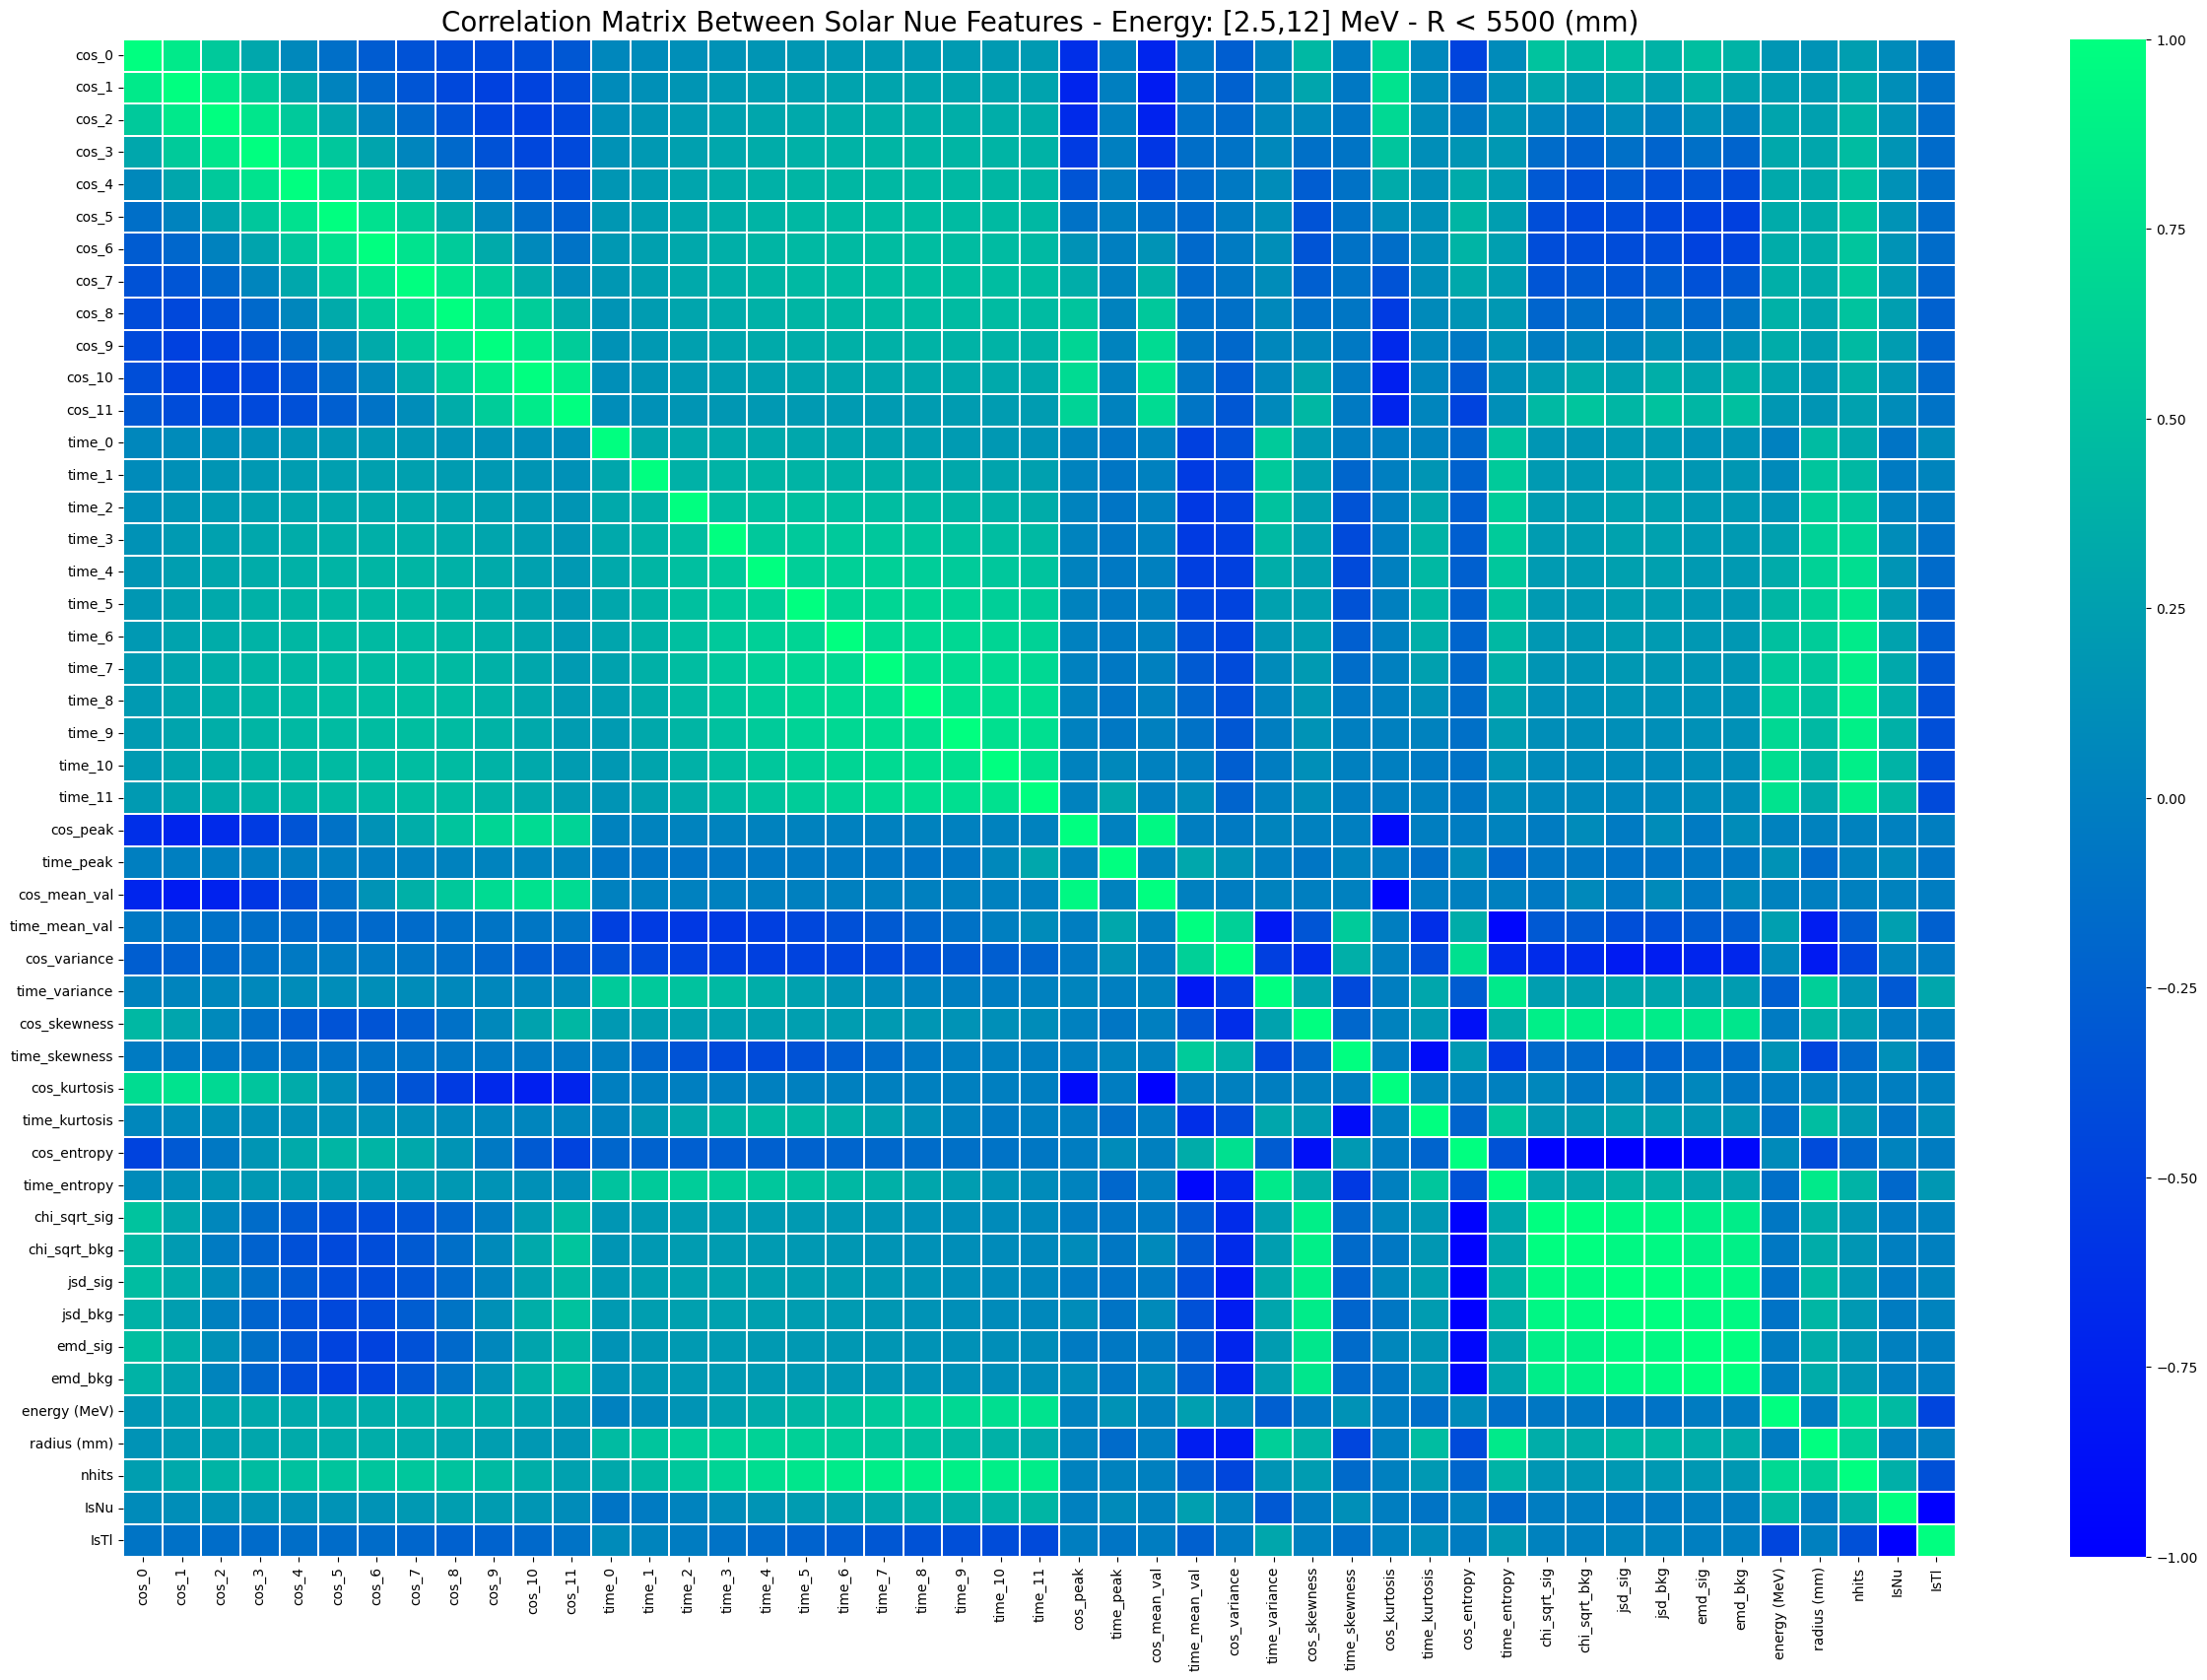

In [15]:
plt.figure(figsize = (30,20))
sn.heatmap(df.corr(), cmap='winter', linewidths= 0.1)#, vmin = -1, vmax = 1)
plt.title('Correlation Matrix Between Solar Nue Features - Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 20)

Text(0.5, 1.0, 'Correlation Matrix Between Solar Nue Features - Energy: [2.5,12] MeV - R < 5500 (mm)')

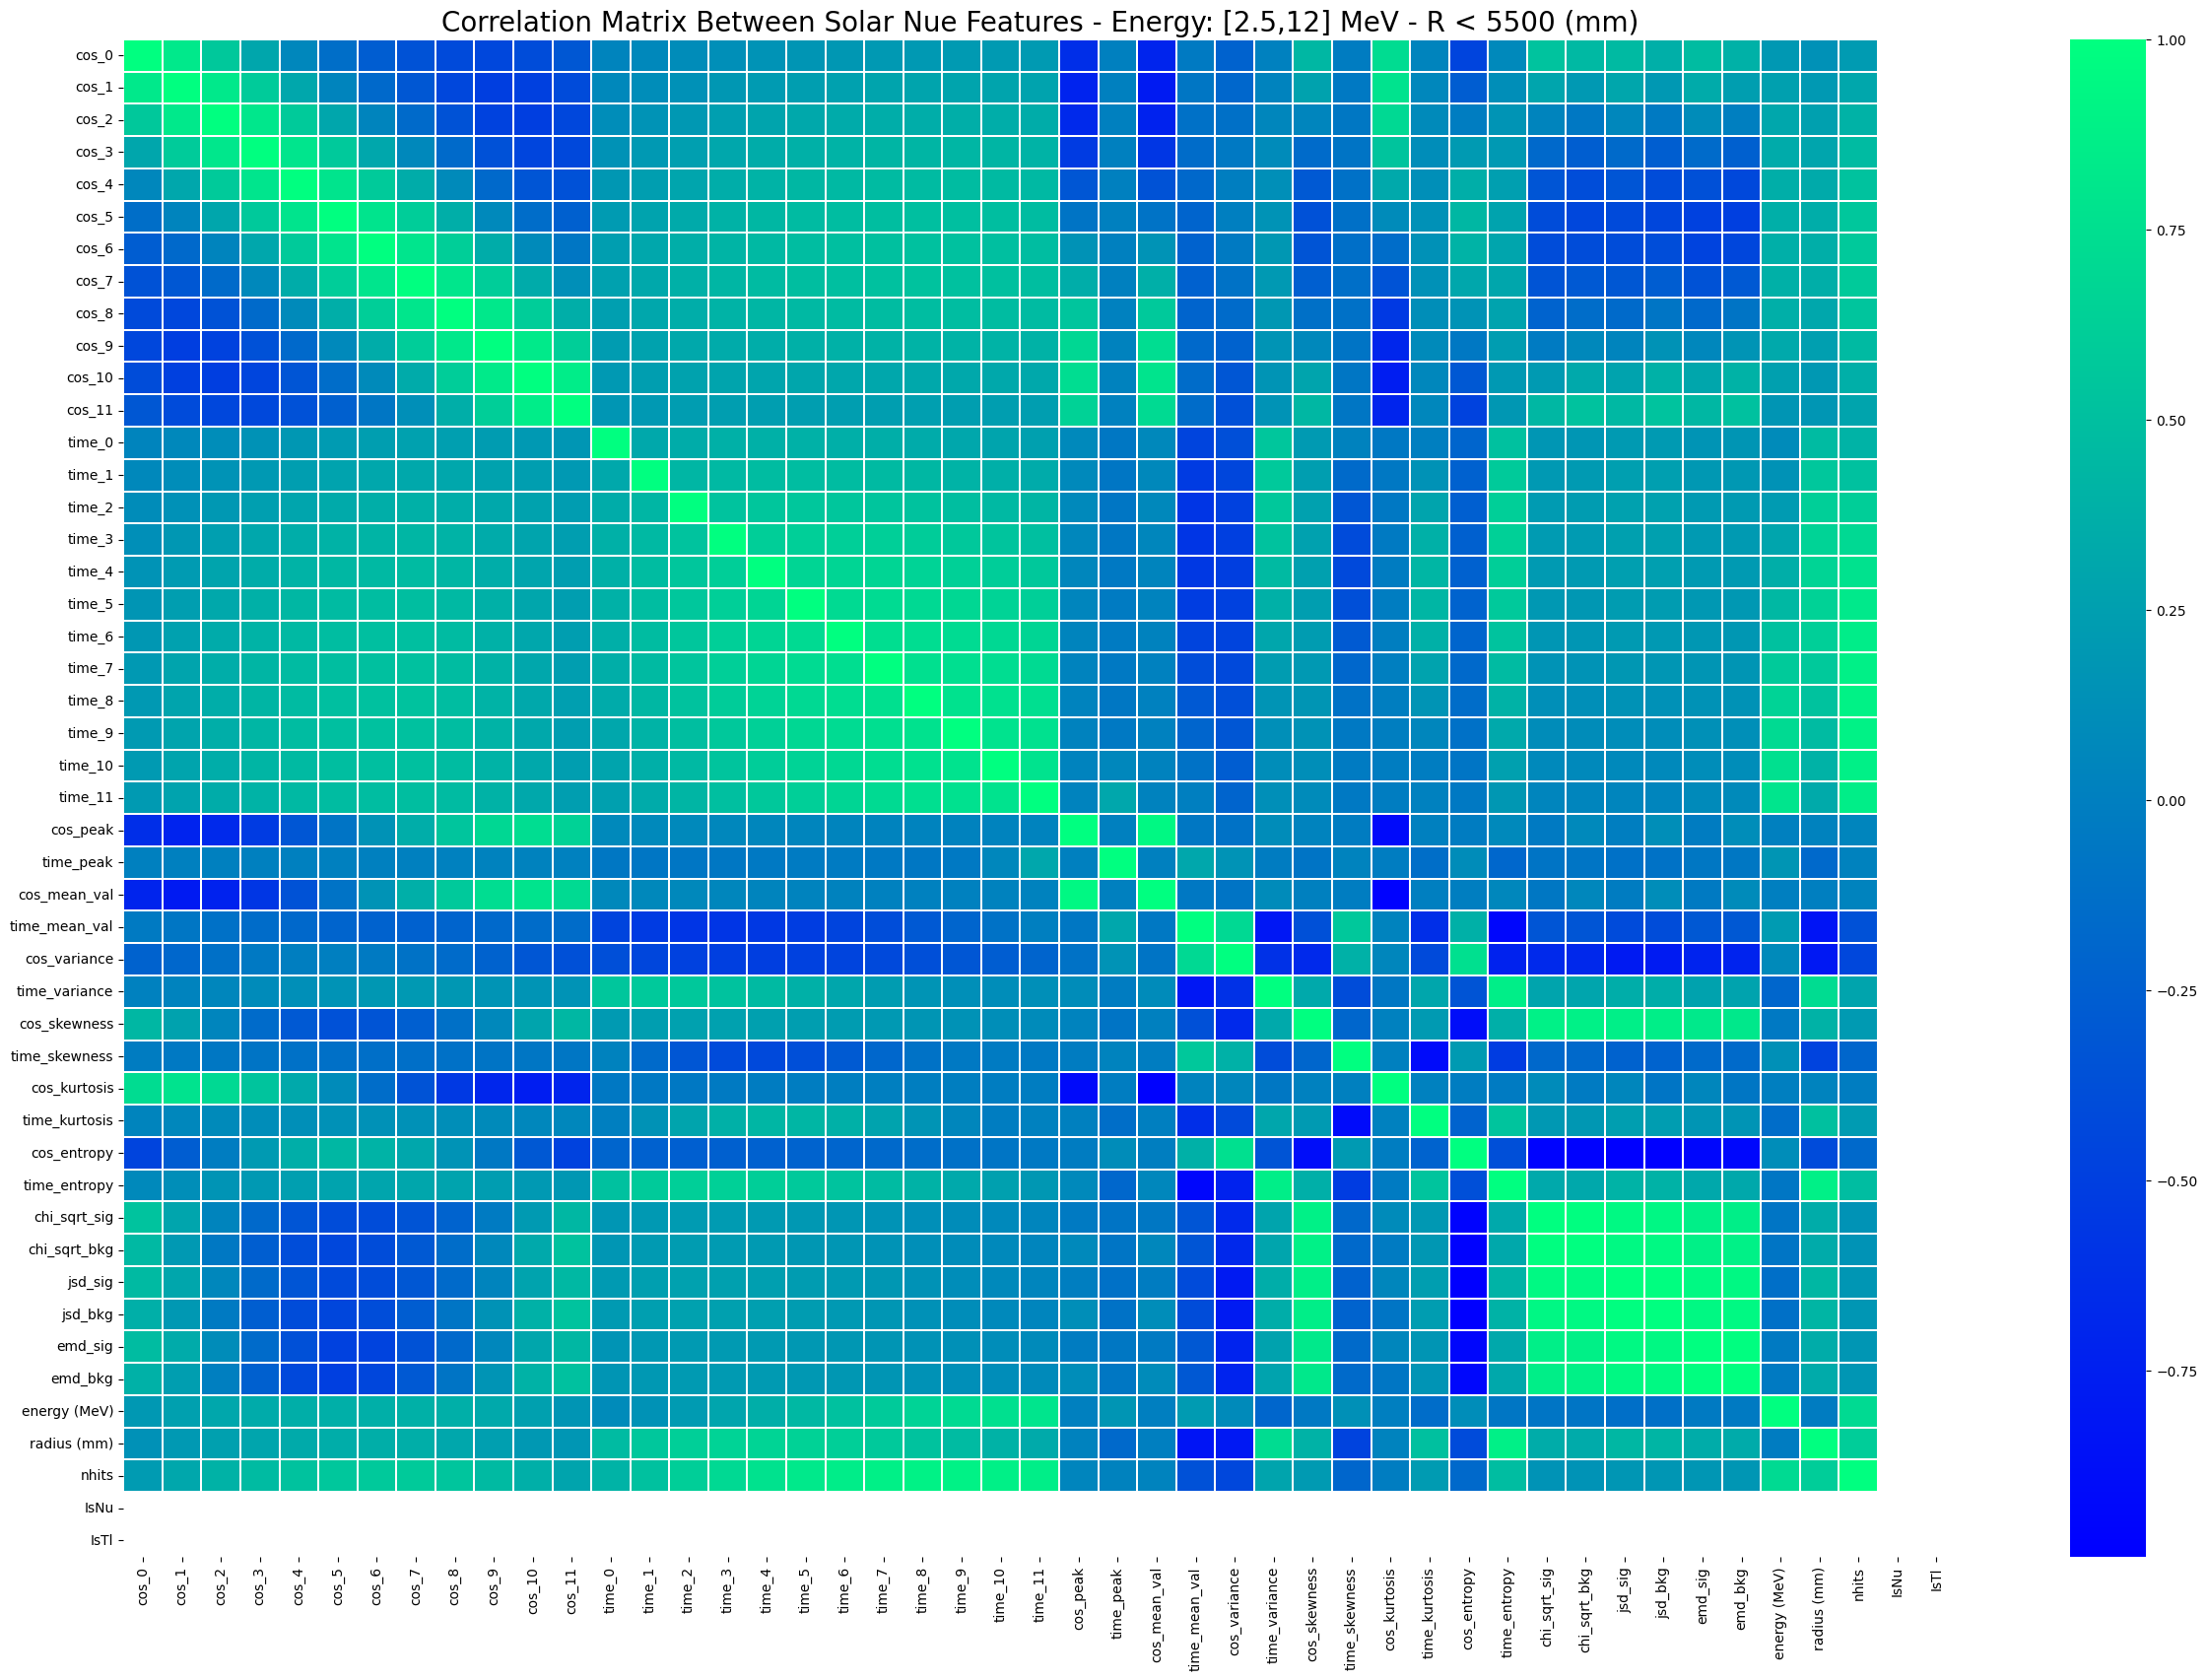

In [16]:
plt.figure(figsize = (30,20))
sn.heatmap(df[df['IsNu'] == 1].corr(), cmap='winter', linewidths= 0.1)#, vmin = -1, vmax = 1)
plt.title('Correlation Matrix Between Solar Nue Features - Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 20)

Text(0.5, 1.0, 'Correlation Matrix Between 208-Tl Features - Energy: [2.5, 12] MeV - R < 5500 (mm)')

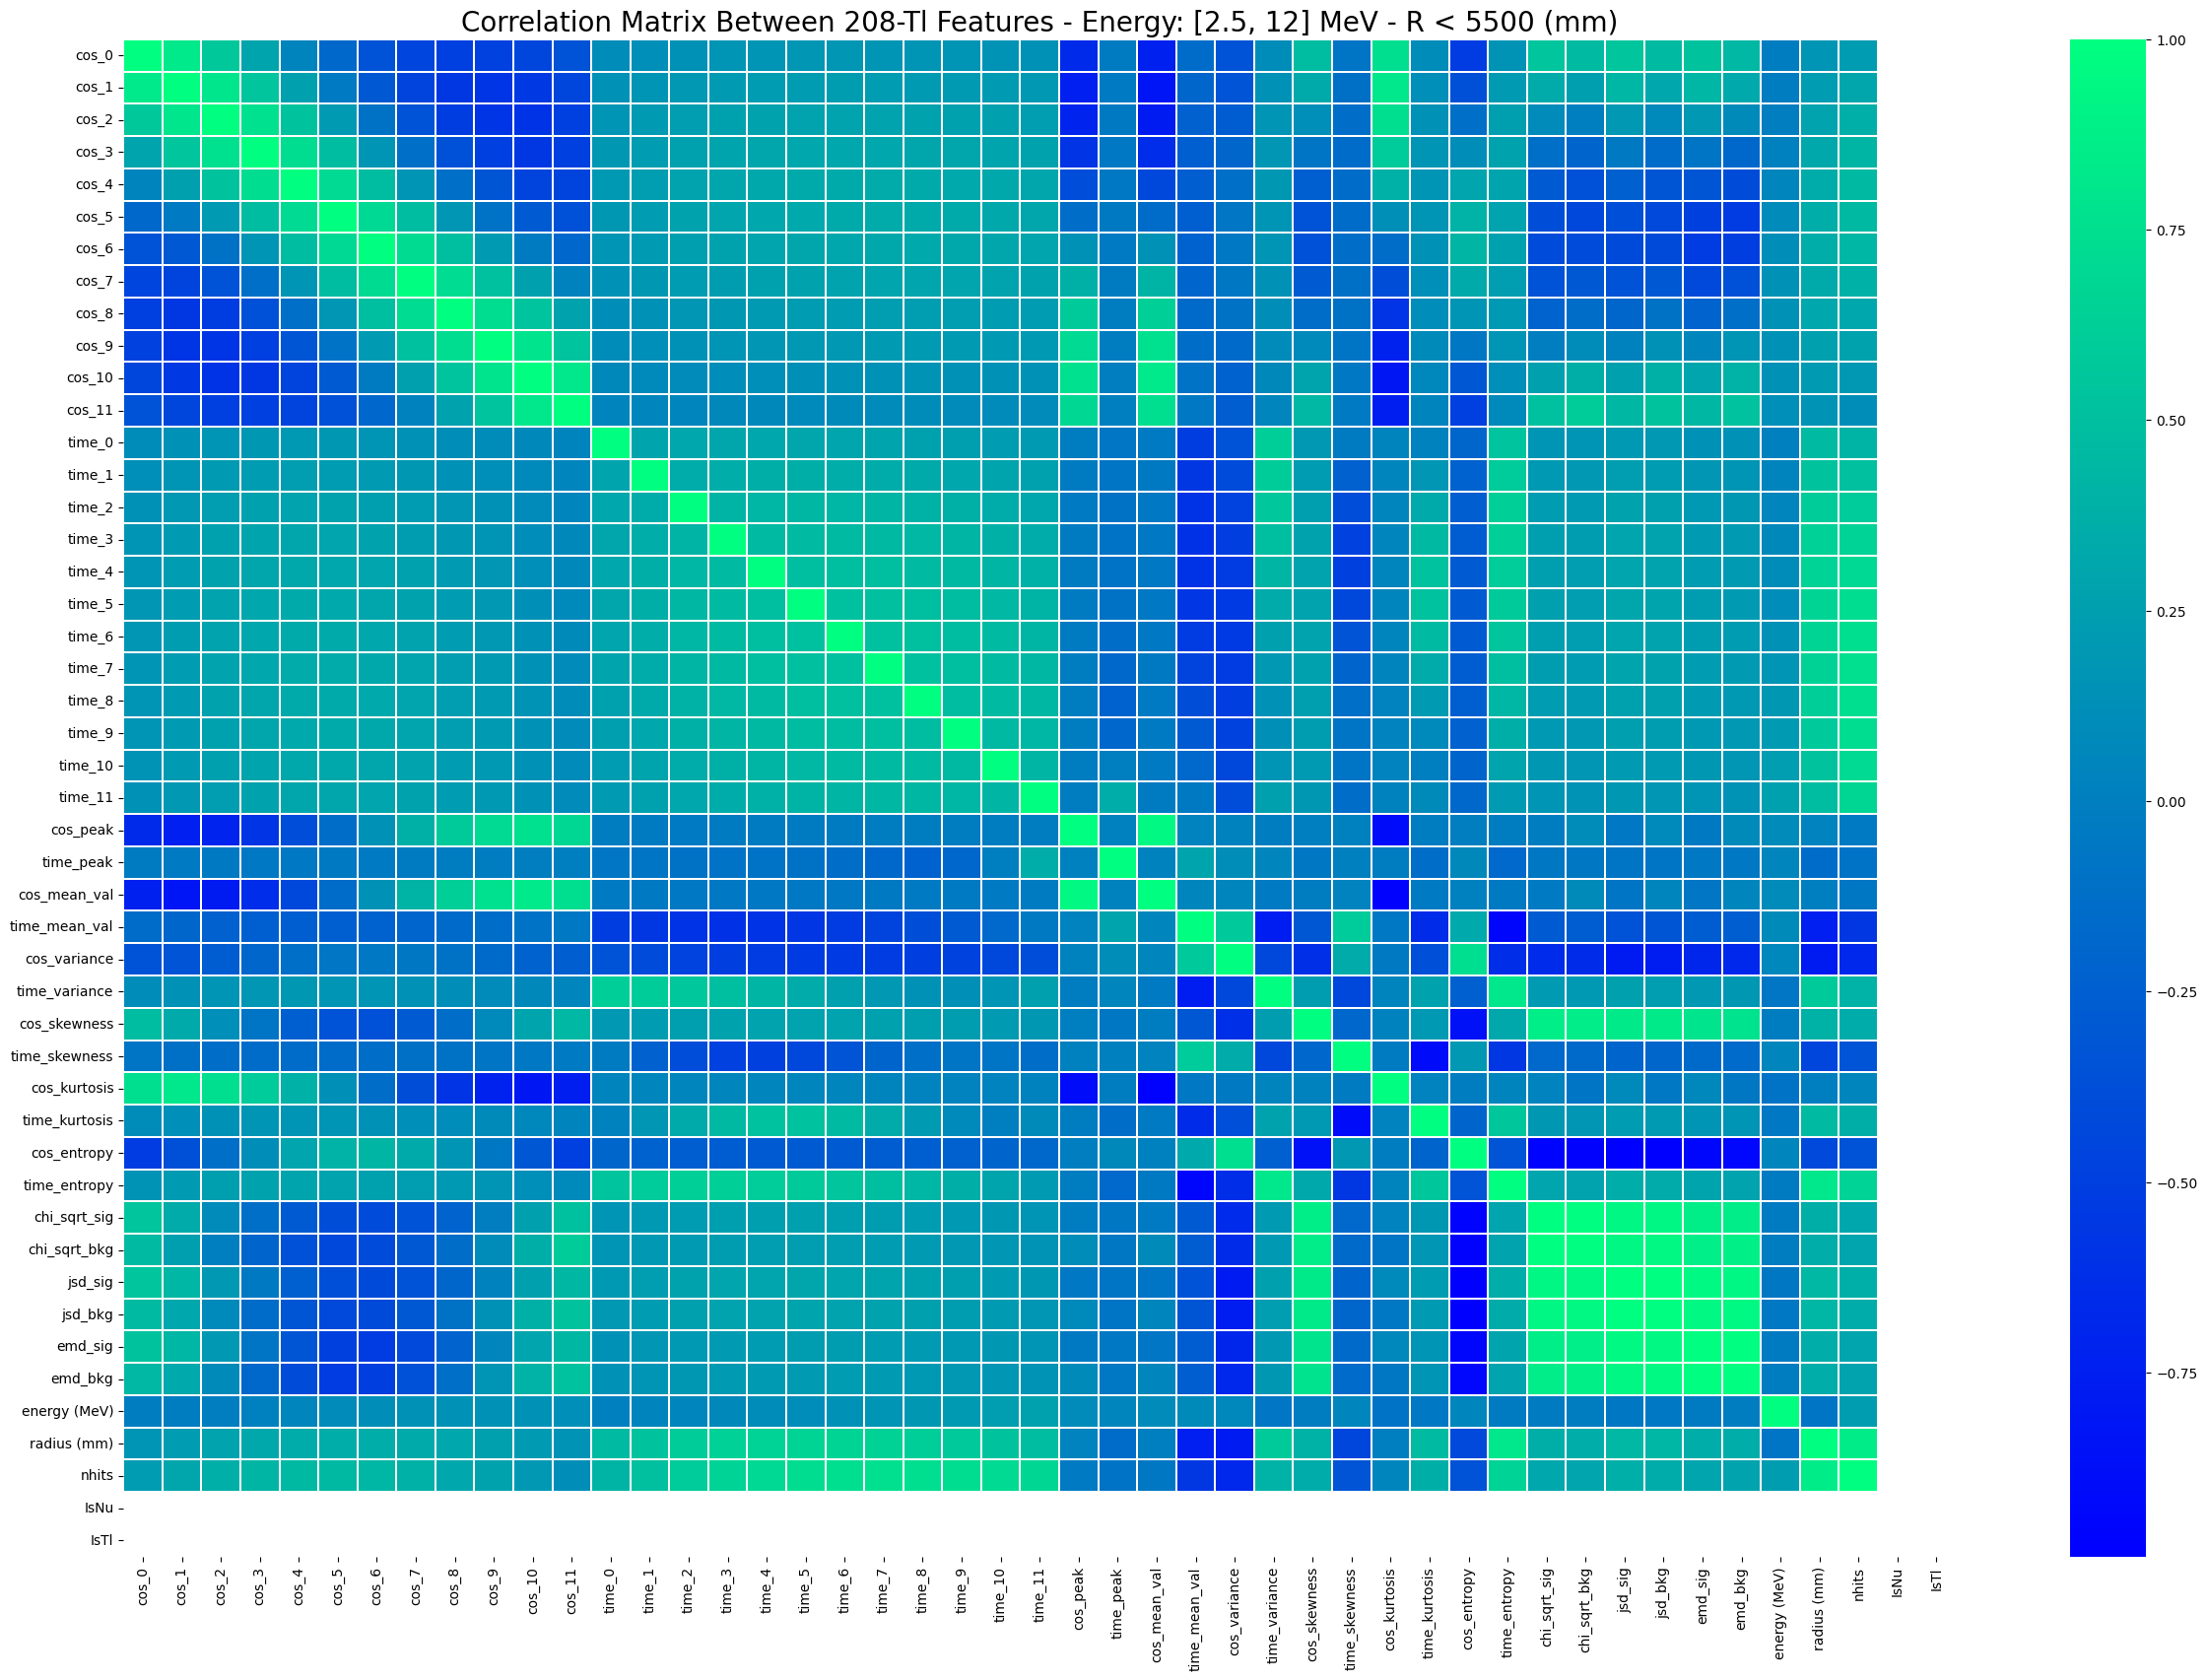

In [17]:
plt.figure(figsize = (30,20))
sn.heatmap(df[df['IsTl'] == 1].corr(), cmap='winter', linewidths= 0.1)#, vmin = -1, vmax = 1)
plt.title('Correlation Matrix Between 208-Tl Features - Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 20)